# Exercise 3: Image Restoration

Tornike Onoprishvili

1. Why image restoration is needed? What causes a need?

As stated in the lecture, image restoration can have multiple objectives. Sometimes it's used for making old photos (with cracks, missing bits, etc) appear more visually "clean".

In other applications (like tracking) restoration can be used for removing motion blur.

One other example would be image noise removal, which can originate from electrical and electromechanical interference in image acquisition. 

2. The captured Lena-image in Fig. 1 contains additive noise, i.e. g ( x , y )=f ( x , y )+n ( x , y ) .
Find out the model or the distribution of the additive noise n(x,y) and also the corresponding
parameters for the distribution. Which assumptions are you using in the modelling? (1 p)

We assume first, that noise is gaussian. 

Estimated parameters for Gaussian distribution:
Mean: 112.18408584594727
Standard Deviation: 34.95029754562943


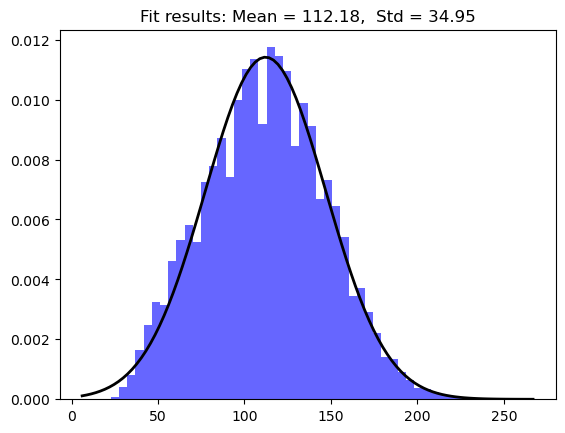

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, describe
from skimage import io, color

# Load the image
image_path = 'Fig1_Lena_n.png'
image = io.imread(image_path)

# Convert the image to grayscale if it's a color image
if image.ndim == 3:
    image = color.rgb2gray(image)

# Flatten the image to a 1D array
image_flat = image.flatten()

# Estimate parameters using Gaussian distribution
mean, std = norm.fit(image_flat)

# Print the estimated parameters
print("Estimated parameters for Gaussian distribution:")
print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

# Plot the histogram and fitted Gaussian distribution
plt.hist(image_flat, bins=50, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title(f"Fit results: Mean = {mean:.2f},  Std = {std:.2f}")
plt.show()


Try out gamma distribution (as all values are strictly positive)

Estimated parameters for Gamma distribution:
Shape: 718.7146280397892
Location: -824.463849931942
Scale: 1.3032012246157452


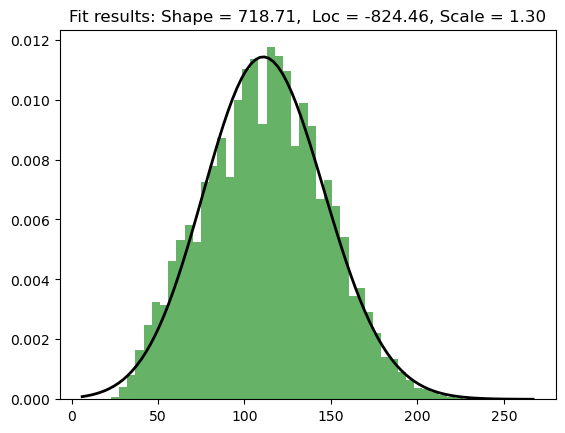

In [3]:
from scipy.stats import gamma

image_flat = image.flatten()
shape, loc, scale = gamma.fit(image_flat)
print("Estimated parameters for Gamma distribution:")
print(f"Shape: {shape}")
print(f"Location: {loc}")
print(f"Scale: {scale}")
plt.hist(image_flat, bins=50, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = gamma.pdf(x, shape, loc, scale)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: Shape = %.2f,  Loc = %.2f, Scale = %.2f" % (shape, loc, scale)
plt.title(title)
plt.show()

3. Apply the median filter and the adaptive median filter to the image given in Fig. 2. Describe
and explain the results you have received. 

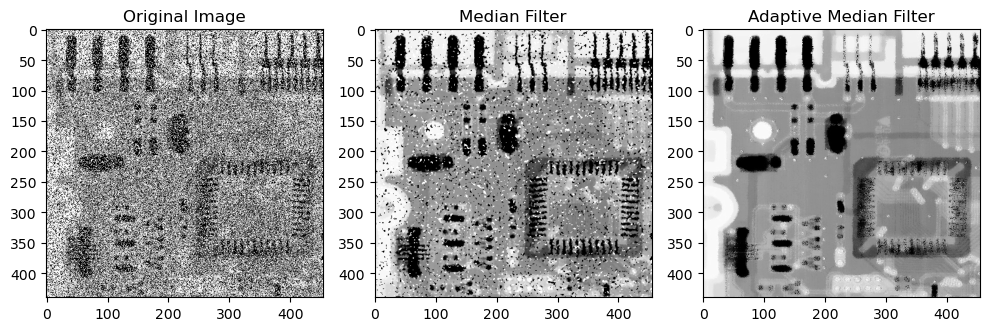

In [4]:

from scipy.ndimage import median_filter
from skimage import io, color

def adaptive_median_filter(img, max_size):
    height, width = img.shape

    result = np.zeros_like(img)

    for i in range(height):
        for j in range(width):
            size = 3
            while size <= max_size:
                window = img[max(0, i - size // 2):min(height, i + size // 2 + 1),
                             max(0, j - size // 2):min(width, j + size // 2 + 1)]

                median_value = np.median(window)

                if img[i, j] > np.min(window) and img[i, j] < np.max(window):
                    result[i, j] = img[i, j]
                    break
                else:
                    result[i, j] = median_value

                size += 2

    return result

# Load the image
image_path = 'Fig2.tif'
image = io.imread(image_path)

# Convert the image to grayscale if it's a color image
if image.ndim == 3:
    image = color.rgb2gray(image)

# Apply median filter
median_filtered = median_filter(image, size=3)

# Apply adaptive median filter
adaptive_median_filtered = adaptive_median_filter(image, max_size=11)

# Plot the original image and the results side-by-side
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(median_filtered, cmap='gray')
plt.title('Median Filter')

plt.subplot(1, 3, 3)
plt.imshow(adaptive_median_filtered, cmap='gray')
plt.title('Adaptive Median Filter')

plt.tight_layout()
plt.show()

4. Remove the (periodic?) noise from the image shown in Fig. 3.

Text(0.5, 1.0, 'magnitude spectrum')

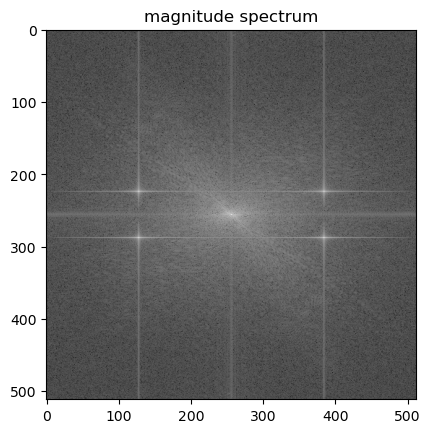

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from scipy.fftpack import fft2, ifft2, fftshift

# Load the image
image_path = 'Fig3_Lena_fn.png'
image = io.imread(image_path)

# notch_centers = [
#     (225, 128),
#     (290, 128),
#     (225, 385),
#     (290, 385),    
    
#     (225, 255),
#     (290, 255),
    
#     (256, 256),
# ]

f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)
phase_spectrumR = np.angle(fshift)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('magnitude spectrum')


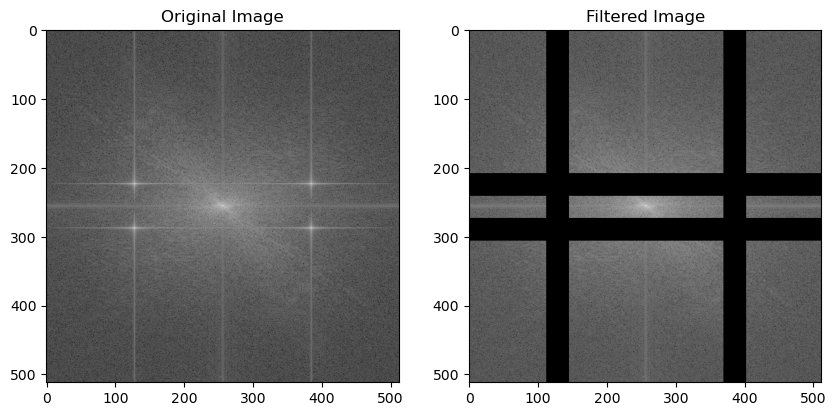

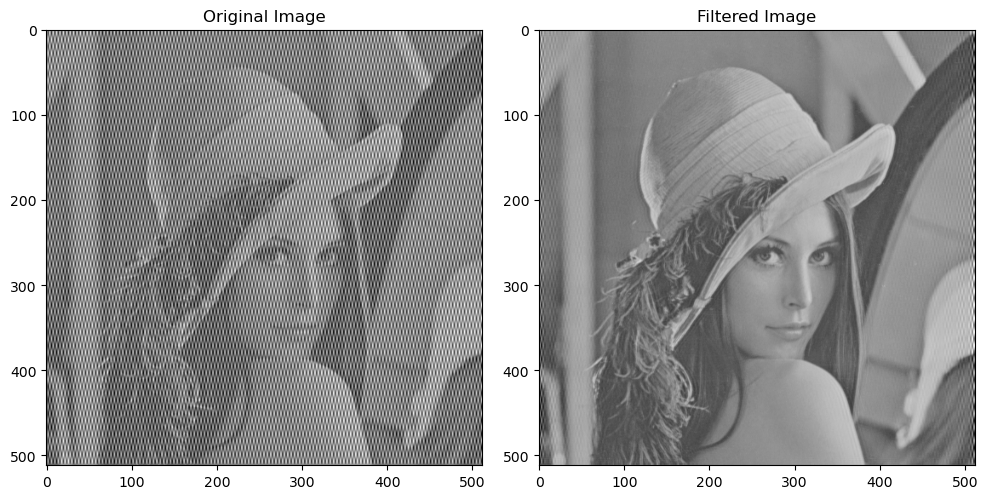

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from scipy.fftpack import fft2, ifft2, fftshift

def notch_filter(image, rows_to_remove, cols_to_remove, width):
    rows, cols = image.shape
    y, x = np.ogrid[:rows, :cols]
    mask = np.ones((rows, cols), dtype=bool)

    # Create masks for specified rows
    for row in rows_to_remove:
        mask[row - width // 2:row + width // 2 + 1, :] = False

    # Create masks for specified columns
    for col in cols_to_remove:
        mask[:, col - width // 2:col + width // 2 + 1] = False

    return mask

def remove_periodic_noise(image, rows_to_remove, cols_to_remove, width):
    # Convert the image to grayscale if it's a color image
    if image.ndim == 3:
        image = color.rgb2gray(image)

    # Compute the 2D Fourier Transform
    fft_image = fft2(image)

    # Apply notch filter for specified rows and columns
    mask = notch_filter(image, rows_to_remove, cols_to_remove, width)
    fft_image = mask * fft_image

    # Inverse Fourier Transform to obtain the filtered image
    filtered_image = np.abs(ifft2(fft_image))
    
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    
    magnitude_spectrum_filt = mask * magnitude_spectrum

    return filtered_image, magnitude_spectrum, magnitude_spectrum_filt

# Load the image
image_path = 'Fig3_Lena_fn.png'
image = io.imread(image_path)

# Specify rows and columns to be removed
rows_to_remove = [225, 290]
cols_to_remove = [128, 385]

# Specify the width of the rectangular region to be suppressed
width = 32

mag_spec = magnitude_spectrum.copy()
F = np.ones_like(mag_spec)
F *= notch_filter(image, rows_to_remove,cols_to_remove, width=width)

# Remove periodic noise using the modified notch filter
filtered_image, spec, spec_filt = remove_periodic_noise(image, rows_to_remove, cols_to_remove, width)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(spec, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(spec_filt, cmap='gray')
plt.title('Filtered Image')



# Plot the original and filtered images side-by-side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap='gray')
plt.title('Filtered Image')

plt.tight_layout()
plt.show()

5. During the imaging, the object has experienced motion. Now the task is to estimate the
degradation function and then reconstruct the original image. The captured, noisy image for
this task is in Fig. 4. First, estimate the motion (in pixels, in which direction) from the image,
use fspecial to design the filter in spatial domain, and perform the reconstruction in the
frequency domain.

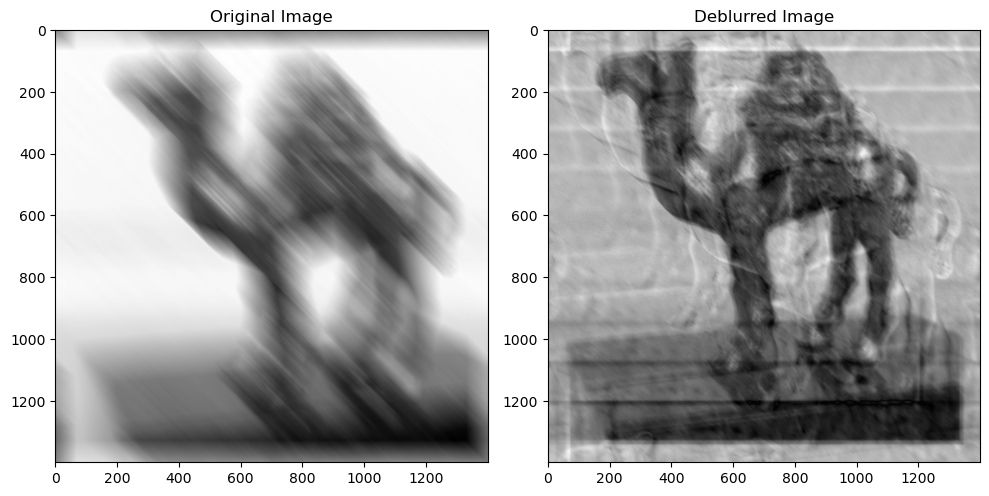

In [219]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from scipy.fftpack import fft2, ifft2, fftshift

def estimate_blur_kernel(size, angle):
    kernel = np.zeros((size, size))
    center = (size - 1) // 2

    # Define a line in the kernel corresponding to the motion blur direction
    for i in range(size):
        x = i - center
        y = int(np.tan(np.radians(angle)) * x + center)
        if 0 <= y < size:
            kernel[i, y] = 1

    return kernel / np.sum(kernel)

def wiener_filter(img, kernel, snr):
    # Compute the 2D Fourier Transform of the image and kernel
    img_fft = fft2(img)
    kernel_fft = fft2(kernel, img.shape)

    # Apply Wiener filter in the frequency domain
    filter_fft = np.conj(kernel_fft) / (np.abs(kernel_fft)**2 + 1 / snr)
    img_filtered_fft = img_fft * filter_fft

    # Inverse Fourier Transform to obtain the filtered image
    img_filtered = np.abs(ifft2(img_filtered_fft))

    return img_filtered

# Load the image
image_path = 'Fig4.png'
image = io.imread(image_path)

# Convert the image to grayscale if it's a color image
if image.ndim == 3:
    image = color.rgb2gray(image)

# Estimate the degradation function (blur kernel)
kernel_size = 64 * 2
blur_angle = -(90 + 45) # Motion blur direction in degrees
blur_kernel = estimate_blur_kernel(kernel_size, blur_angle)

# Apply Wiener filter for deblurring
snr = 1000
deblurred_image = wiener_filter(image, blur_kernel, snr)

# Plot the original and deblurred images side-by-side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(deblurred_image, cmap='gray')
plt.title('Deblurred Image')

plt.tight_layout()
plt.show()
